In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from denn import *
import torch
from torch import nn, functional as F

In [2]:
path = Path('../../data/large')

In [3]:
ab = pd.read_csv(path/'dC_01.csv', header=None).values[0]
bestKnow = pd.read_csv(path/'Best_Know1Fxs.csv', header=None).values[0][:100].astype(float)
bestKnow_sum_constraints = pd.read_csv(path/'Best_Know1SumCV.csv', header=None).values[0][:100].astype(float)
java_results = pd.read_csv(path/'Feasibility1Fs.csv', header=None).values[0]
java_results = java_results[:-1].astype(float)
java_results_all = pd.read_csv(path/'Feasibility1Fs.csv', header=None).iloc[:,:-1]

In [4]:
D = 30
nn_window = 5
nn_nf = 4
frequency = 1_000
max_times = len(ab)
total_generations = max_times * frequency + 1000

In [5]:
class SimpleModel(nn.Module):
    def __init__(self, d=D, w=nn_window, nf=nn_nf):
        super().__init__()
        self.fc1 = nn.Linear(d,nf)
        self.fc2 = nn.Linear(nf*w,d)
        self.act = nn.ReLU(inplace=True)
        
    def forward(self, x):
        fts = torch.cat([self.fc1(x[:,i]) for i in range(x.size(1))], dim=1)
        return self.fc2(self.act(fts))

model = SimpleModel()

In [6]:
def fitness_func(indiv, b, t): return (indiv.data**2).sum()
def constraint_func(indiv, b, t): return -b[t] + sum((1/np.sqrt(D))*indiv.data)

population = Population.new_random(dimension=D)
nn_trainer = partial(NNTrainer, model=model, window=nn_window)
speed_metric = partial(SpeedMetric, threadhold=0.1)

opt = Optimization(population, fitness_func, constraint_func, constraint_params=[ab],
                   max_times=max_times, frequency=frequency, callbacks=[nn_trainer], metrics=[speed_metric],
                   optimal_fitness_values=bestKnow, optimal_sum_constraints=bestKnow_sum_constraints)
opt.state_dict

{'gen': 0, 'evals': 0, 'time': 0, 'time_evals': 0, 'best': None}

Total time: 00:32


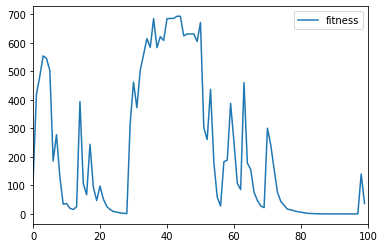

In [7]:
opt.run(total_generations)

In [25]:
opt.speed_metric.metrics

{84: 810,
 85: 8,
 86: 40,
 87: 8,
 88: 40,
 89: 8,
 90: 40,
 91: 8,
 92: 40,
 93: 8,
 94: 40,
 95: 8,
 96: 40,
 97: 8}

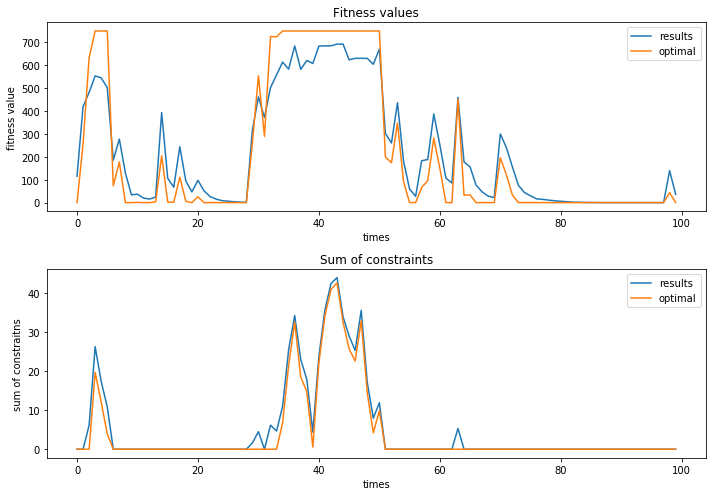

In [14]:
opt.recorder.plot();

In [26]:
pred = opt.nn_trainer.get_next_best()
pred

tensor([-5.1924e-02, -4.2251e-01, -1.2029e+00, -1.6166e+00, -7.8819e-01,
        -1.6862e+00, -8.0932e-01, -9.1241e-01,  1.2130e-01, -1.9030e-01,
         2.5651e-01, -8.0253e-01,  5.6027e-01, -1.3818e+00,  2.7601e-01,
        -8.1727e-01, -1.3966e-01, -3.5766e-01, -4.1890e-01, -6.6936e-01,
        -8.3050e-01,  3.6925e-01,  3.5981e-01,  3.4179e-02, -9.2781e-01,
         3.8252e-01, -6.3422e-01,  1.1720e-03, -1.1838e+00, -5.8052e-01])

In [29]:
fitness_func(opt.best, 0, 0), fitness_func(pred, 0, 0)

(36.265007, tensor(17.7975))

In [30]:
constraint_func(opt.best, ab, opt.time-1), constraint_func(pred, ab, opt.time-1)

(-17.60943594673276, tensor(-19.8116))

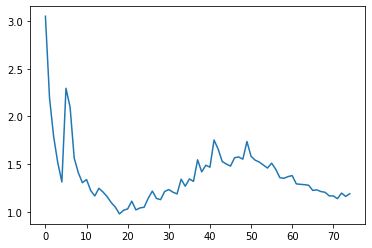

In [31]:
plt.plot(opt.nn_trainer.train_losses)